# Portfolio de Implementacion
## Implementación de un modelo de deep learning

Juan Carlos Corona Vega

A01660135



## Introducción

### Planteamiento del problema

En este trabajo se pretende clasificar imágenes de señalamientos de tráfico que se encuentran habitualmente en las calles y carreteras.

Con la creciente complejidad de los sistemas de carreteras y la necesidad de sistemas avanzados de asistencia al conductor, el reconocimiento preciso y rápido de las señales de tráfico es fundamental para garantizar la seguridad vial y mejorar la eficiencia general del transporte.

### Relevancia del dataset

La clasificación precisa de las señales de tráfico es fundamental para los sistemas de transporte inteligentes, los vehículos autónomos y los sistemas avanzados de asistencia al conductor.

Identificar y comprender eficazmente el significado de las distintas señales de tráfico, como los límites de velocidad, las advertencias y las instrucciones reglamentarias, es esencial para garantizar una conducción segura y respetuosa con la ley.

A criterio propio,considero que este conjunto de datos proporciona un valioso recurso para desarrollar y entrenar modelos de aprendizaje automático para contribuir al avance de las tecnologías destinadas a mejorar la seguridad vial y la gestión del tráfico.

## Datos y Preprocesamiento

El conjunto de datos mencionado se obtiene de la plataforma Kaggle y por motivos prácticos, se carga mediante el API de Kaggle. A continuación se muetsra el proceso de obtención de los datos.

In [56]:
# Instalacion de librerias
! pip install kaggle

In [39]:
# Importar librerías
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
import cv2
import warnings
from google.colab import files
import zipfile
import shutil

warnings.filterwarnings('ignore')

In [29]:
def create_and_move_folder(existing_folder_path, new_parent_folder_path, new_folder_name):
    # Create the new folder
    new_folder_path = os.path.join(new_parent_folder_path, new_folder_name)
    os.makedirs(new_folder_path, exist_ok=True)

    # Move the existing folder inside the new folder
    shutil.move(existing_folder_path, new_folder_path)

In [2]:
# configuracion del API de Kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Configuracion de directorios
os.makedirs('/root/.kaggle/', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# Configuracion de permisos
os.chmod('/root/.kaggle/kaggle.json', 600)

In [4]:
dataset_path = '/content/traffic-sign-dataset-classification.zip'
! kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification --force

 99% 187M/190M [00:05<00:00, 42.6MB/s]
100% 190M/190M [00:05<00:00, 33.6MB/s]


In [5]:
# Extraccion del dataset
import zipfile
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Configurar el conjunto de datos y las etiquetas
dataset = '/content/traffic_Data/DATA'
label_file_path = '/content/labels.csv'
labelfile = pd.read_csv(label_file_path)

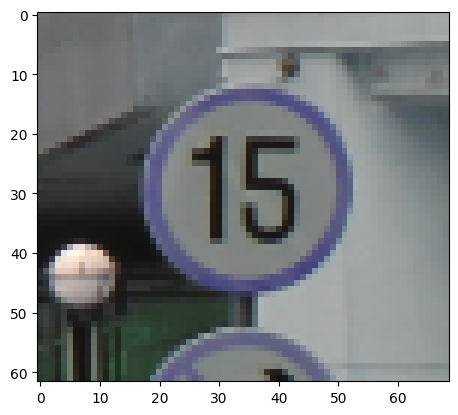

In [6]:
# Visualizar dataset
img = cv2.imread(dataset + '/1/001_0001.png')
plt.imshow(img)

In [8]:
# labels
labelfile.head()

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [9]:
labelfile['Name'].value_counts()

Bicycles crossing               2
Speed limit (40km/h)            2
Speed limit (50km/h)            2
Go left or straight             1
Road Divider                    1
Traffic signals                 1
Danger Ahead                    1
Zebra Crossing                  1
Children crossing               1
Dangerous curve to the left     1
Dangerous curve to the right    1
Unknown1                        1
Unknown2                        1
Unknown3                        1
Go right or straight            1
Speed limit (5km/h)             1
Unknown4                        1
Uturn                           1
Train Crossing                  1
Under Construction              1
Unknown5                        1
Fences                          1
Heavy Vehicle Accidents         1
Unknown6                        1
Give Way                        1
No stopping                     1
No entry                        1
Unknown7                        1
ZigZag Curve                    1
Horn          

In [10]:
# Definir datasets de entrenamiento y validación
train_ds = image_dataset_from_directory(dataset, validation_split=0.2,
															subset='training',
															image_size=(224, 224),
															seed=123,
															batch_size=32)

val_ds = image_dataset_from_directory(dataset, validation_split=0.2,
															subset='validation',
															image_size=(224, 224),
															seed=123,
															batch_size=32)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.
Found 4170 files belonging to 58 classes.
Using 834 files for validation.


De las celdas anteriores, podemos notar que el conjunto de datos para la construcción del modelo (4170 fotografías) cuenta con 58 diferentes categorías de señalización (límites de velocidad, indicadores de dirección, indicaciones de vueltas, etc.)

Este es dividido en el conjunto de entrenamiento y validación (80-20 respectivamente). A continuación se asignan las etiquetas con las imágenes para proceder con el entrenamiento del modelo:


In [11]:
# Asignar etiquetas a imagenes
class_numbers = train_ds.class_names
class_names = []
for i in class_numbers:
	class_names.append(labelfile['Name'][int(i)])

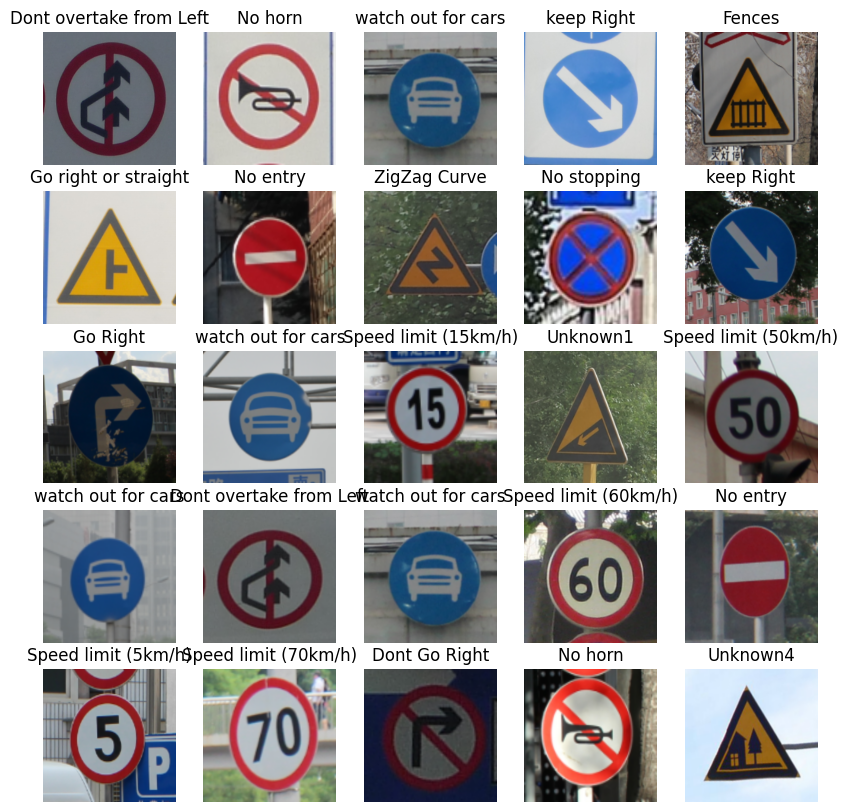

In [12]:
# Mostar imagenes con sus respectivas etiquetas
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
	for i in range(25):
		ax = plt.subplot(5, 5, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

plt.show()

In [13]:
# Data Augmentation
data_aug= tf.keras.Sequential(
	[
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224, 3)),
	tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
	tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
	tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical")
	]
)


Para este conjunto de datos se utilizó data augmentation para aumentar artificialmente la diversidad del conjunto de datos de entrenamiento mediante inversiones, rotaciones, zoom, reencuadre, entre otras. Esto ayuda al modelo a generalizar mejor los datos no vistos y mejora su robustez.

## Desarrollo del modelo

Para este primer modelo se ha implementado una red neuronal convolucional para clasificar las imagenes, con capas convolucionales y de agrupación (pooling) para la extracción de características, seguidas de capas densamente conectadas para la clasificación.

En la siguiente celda se muestra la construcción del modelo a detalle:

In [43]:
# Generacion del Modelo

model = Sequential()

model.add(data_aug) # Se agregan los datos augmentados al modelo
model.add(Rescaling(1./255)) # se cambia el tamaño de las imagenes


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dense(len(labelfile), activation='softmax'))

Las capas convolucionales de una red neuronal convolucional (CNN) aplican filtros para extraer características como bordes y texturas de los datos de entrada.

La capa de agrupación (pooling) posterior a las convolucionales, reducen las dimensiones espaciales reteniendo la información más importante, lo que mejora la eficiencia computacional y promueve la invariancia de traslación, haciendo que la red sea robusta a las variaciones en la posición del objeto dentro de la entrada.



La capa de aplanamiento de una red neuronal transforma la salida 3D de las capas convolucionales y de agrupamiento en un vector 1D. Esta representación aplanada se introduce en dos capas densas, que sirven de transición entre las características jerárquicas aprendidas y las predicciones de clase.

Las capas densas utilizan neuronas totalmente conectadas para captar relaciones complejas y tomar las decisiones finales de clasificación basadas en las características aprendidas.

In [44]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
			optimizer='adam',
			metrics=['accuracy'])

Se utiliza la función de pérdida Sparse Categorical Crossentropy para medir la diferencia entre las etiquetas de clase predichas y las reales.

El optimizador 'adam' se emplea para minimizar esta pérdida durante el entrenamiento, y la métrica de precisión se controla para evaluar el rendimiento del modelo.

En la siguiente celda se configura el entrenamiento del modelo y funciones de callback EarlyStopping para monitorear la pérdida de validación y detiene el entrenamiento si la pérdida no mejora durante cinco épocas consecutivas.

El modelo se entrena en el conjunto de datos **train_ds**, se valida en el conjunto de datos **val_ds** y el historial de entrenamiento se almacena para su análisis. El entrenamiento continúa durante un máximo de 50 épocas.

In [45]:
# Set callback functions to early stop training
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(train_ds,
				validation_data=val_ds,
				epochs=50,
				callbacks=mycallbacks)

Epoch 1/50
105/105 [==============================] - 20s 149ms/step - loss: 3.2083 - accuracy: 0.2008 - val_loss: 2.3123 - val_accuracy: 0.3549
Epoch 2/50
105/105 [==============================] - 15s 137ms/step - loss: 2.2411 - accuracy: 0.3576 - val_loss: 1.9709 - val_accuracy: 0.3825
Epoch 3/50
105/105 [==============================] - 14s 133ms/step - loss: 1.9513 - accuracy: 0.3846 - val_loss: 1.5474 - val_accuracy: 0.5204
Epoch 4/50
105/105 [==============================] - 14s 133ms/step - loss: 1.7024 - accuracy: 0.4568 - val_loss: 1.5588 - val_accuracy: 0.4976
Epoch 5/50
105/105 [==============================] - 14s 132ms/step - loss: 1.6029 - accuracy: 0.4790 - val_loss: 1.2933 - val_accuracy: 0.5983
Epoch 6/50
105/105 [==============================] - 14s 131ms/step - loss: 1.4722 - accuracy: 0.5207 - val_loss: 1.2441 - val_accuracy: 0.5911
Epoch 7/50
105/105 [==============================] - 14s 133ms/step - loss: 1.3879 - accuracy: 0.5456 - val_loss: 1.0904 - val_ac

In [46]:
model.save('/content/traffic_Data')

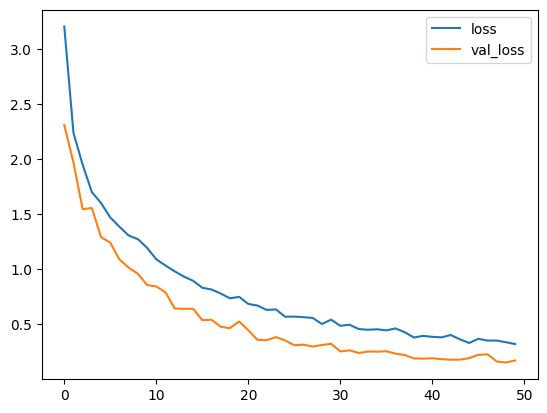

In [47]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')

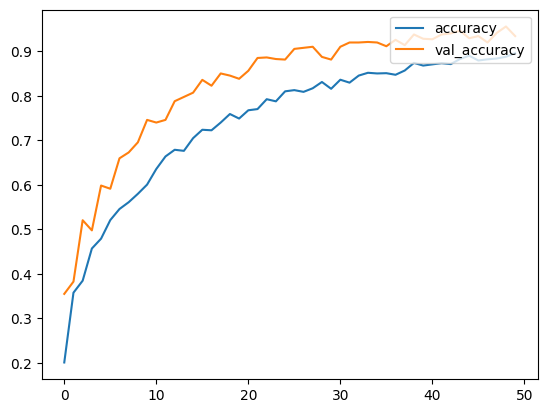

In [48]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')

#### Resultados del Entrenamiento

- El entrenamiento comienza con una pérdida relativamente alta y una precisión más baja, pero ambas mejoran con el paso de las épocas.

- Las métricas de validación (val_loss y val_accuracy) se controlan para evaluar la generalización del modelo en datos no vistos.

- En general, a medida que avanzan las épocas, la pérdida de entrenamiento disminuye y la precisión del entrenamiento aumenta.

- En este caso, el modelo alcanza una precisión de validación relativamente alta (~95%), lo que indica una buena generalización a datos no vistos.


## Ajuste del Modelo

Se realizarán cambios a los parámetros del modelo una vez realizadas las predicciones para datos nuevos que jamás ha visto el modelo hasta este punto.

A continuación se muestran las predicciones:

In [50]:
existing_folder_path = "/content/traffic_Data/TEST"
new_parent_folder_path = "/content/traffic_Data/"
new_folder_name = "TestDataset"

create_and_move_folder(existing_folder_path, new_parent_folder_path, new_folder_name)

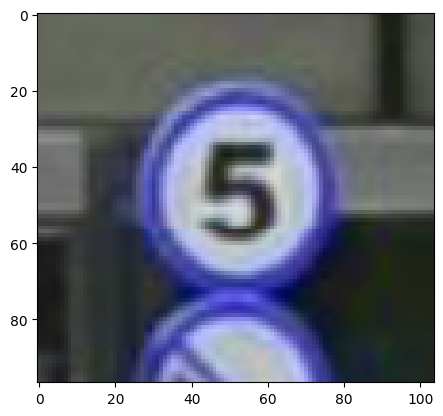

In [51]:
# Visualizar dataset
test_dataset = "/content/traffic_Data/TestDataset/TEST/"
img = cv2.imread(test_dataset + '000_0006_j.png')
plt.imshow(img)

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/traffic_Data/TestDataset/",
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 1994 images belonging to 1 classes.


In [53]:
predictions = model.predict(test_generator)

63/63 [==============================] - 4s 63ms/step


In [76]:
np.argmax(predictions[345])

50

In [60]:
predicted_labels = np.argmax(predictions, axis=1)
file_names = test_generator.filenames
base_directory = test_generator.directory
file_paths = [os.path.join(base_directory, file_name) for file_name in file_names]

In [57]:
num_samples = 25  # Adjust this based on the number of images you want to visualize
random_indices = random.sample(range(len(file_paths)), num_samples)

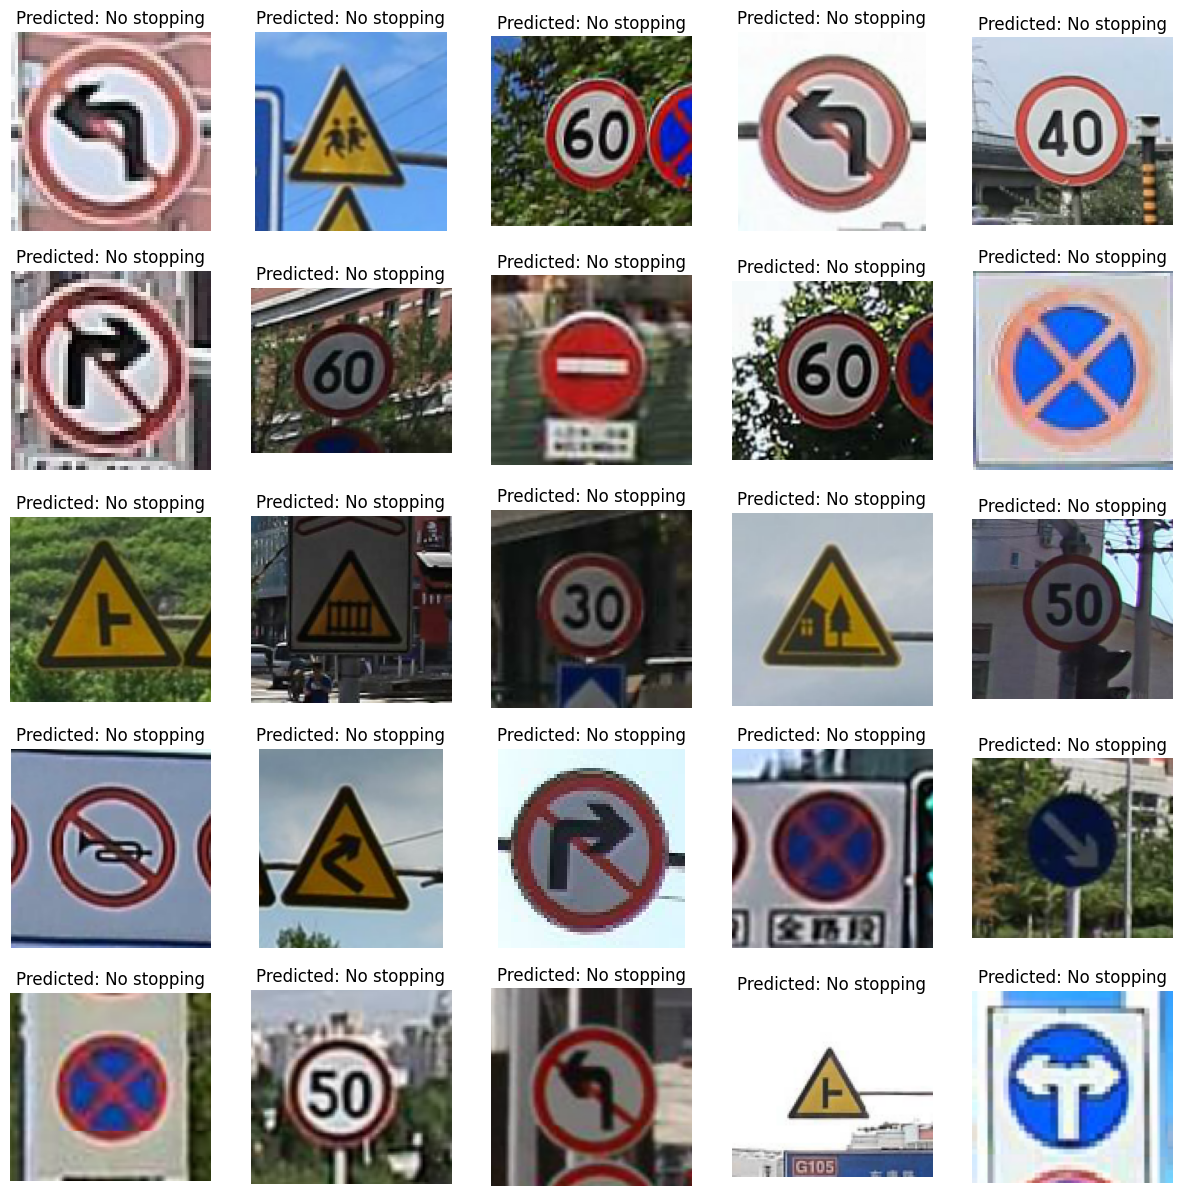

In [58]:
plt.figure(figsize=(15, 15))
for i, index in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)

    # Load and display the image
    img = plt.imread(file_paths[index])
    plt.imshow(img)

    # Display the predicted label
    predicted_label = class_names[predicted_labels[index]]

    plt.title(f'Predicted: {predicted_label}')
    plt.axis("off")

plt.show()

Basado en el entrenamiento del modelo y sus respectivos resultados, se ha optado por entrenar otro modelo con diferente tipo de monitoreo para la función de Callback de EarlyStopping.

Como se pudo observar en el entrenamiento, el modelo se entrenó surante las 50 epocas. Al cambiar la métrica a monitorear a "val_accuracy", se espera que el modelo obtenga buenos resultados en un menor tiempo. A continuación, se muestra el cambio:

In [93]:
# Generacion del Modelo

model_modified = Sequential()

model_modified.add(data_aug) # Se agregan los datos augmentados al modelo
model_modified.add(Rescaling(1./255)) # se cambia el tamaño de las imagenes


model_modified.add(Conv2D(128, (3, 3), activation='relu'))
model_modified.add(MaxPooling2D((2, 2)))

model_modified.add(Conv2D(64, (3, 3), activation='relu'))
model_modified.add(MaxPooling2D((2, 2)))

model_modified.add(Conv2D(128, (3, 3), activation='relu'))
model_modified.add(MaxPooling2D((2, 2)))

model_modified.add(Conv2D(256, (3, 3), activation='relu'))
model_modified.add(MaxPooling2D((2, 2)))

model_modified.add(Flatten())

model_modified.add(Dense(64, activation='relu'))
model_modified.add(Dropout(0.2))

model_modified.add(Dense(128, activation='relu'))
model_modified.add(Dense(len(labelfile), activation='softmax'))

In [94]:
model_modified.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
			optimizer='adam',
			metrics=['accuracy'])

In [95]:
# Set callback functions to early stop training
mycallbacks = [EarlyStopping(monitor='val_accuracy', patience=5)]
history = model_modified.fit(train_ds,
				validation_data=val_ds,
				epochs=50,
				callbacks=mycallbacks)

Epoch 1/50
105/105 [==============================] - 18s 139ms/step - loss: 3.2181 - accuracy: 0.1808 - val_loss: 2.5309 - val_accuracy: 0.3153
Epoch 2/50
105/105 [==============================] - 14s 133ms/step - loss: 2.4274 - accuracy: 0.3264 - val_loss: 1.9532 - val_accuracy: 0.4484
Epoch 3/50
105/105 [==============================] - 15s 136ms/step - loss: 1.9603 - accuracy: 0.4149 - val_loss: 1.6073 - val_accuracy: 0.4760
Epoch 4/50
105/105 [==============================] - 14s 130ms/step - loss: 1.7378 - accuracy: 0.4592 - val_loss: 1.4382 - val_accuracy: 0.5504
Epoch 5/50
105/105 [==============================] - 15s 140ms/step - loss: 1.5804 - accuracy: 0.4841 - val_loss: 1.3305 - val_accuracy: 0.5803
Epoch 6/50
105/105 [==============================] - 14s 131ms/step - loss: 1.4864 - accuracy: 0.5219 - val_loss: 1.1698 - val_accuracy: 0.6415
Epoch 7/50
105/105 [==============================] - 14s 129ms/step - loss: 1.3995 - accuracy: 0.5327 - val_loss: 1.2152 - val_ac

In [96]:
model_modified.save('/content/traffic_Data')

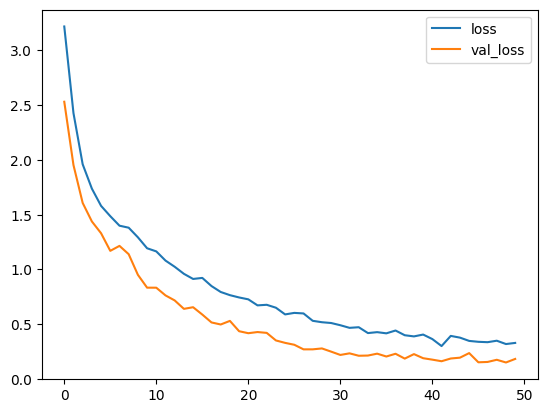

In [97]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')

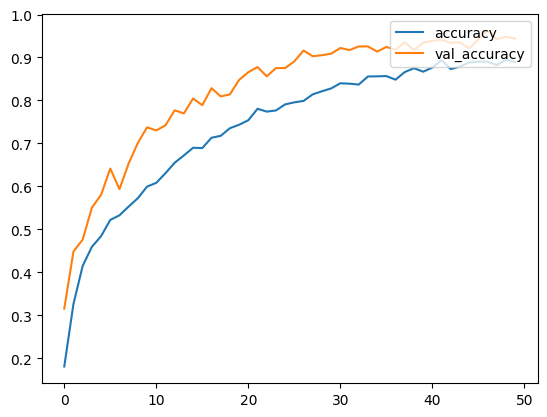

In [98]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')

Del entrenamiento y de los resultados podemos observar que prácticamente no sufrió cambios relevantes al cambiar el parámetro de monitoreo para EarlyStopping.

A continuación, se propone otro tipo de arquitectura de modelo de entrenamiento para evaluar su desempeño en entrenamiento y precisión


In [14]:
# Tercera propuesta de modelo (cambio en la arquitectura)
model_alternative = Sequential()

model_alternative.add(data_aug)
model_alternative.add(Rescaling(1./255))

model_alternative.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_alternative.add(MaxPooling2D((2, 2)))

model_alternative.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_alternative.add(MaxPooling2D((2, 2)))

model_alternative.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_alternative.add(MaxPooling2D((2, 2)))

model_alternative.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_alternative.add(MaxPooling2D((2, 2)))

model_alternative.add(GlobalAveragePooling2D())

model_alternative.add(Dense(128, activation='relu'))
model_alternative.add(Dropout(0.3))

model_alternative.add(Dense(64, activation='relu'))
model_alternative.add(Dropout(0.3))

model_alternative.add(Dense(len(labelfile), activation='softmax'))

Con estos cambios se espera lo siguiente:

- Se introducen capas convolucionales adicionales, mejorando su capacidad para captar características jerárquicas en los datos.

- La incorporación de Global Average Pooling reduce el número de parámetros, lo que puede evitar el sobreajuste y mejorar la generalización.

- Las capas de abandono ayudan a mitigar el sobreajuste desactivando neuronas aleatoriamente durante el entrenamiento.

En general, se espera obtener un mejor modelo a comparación del primero y del segundo.

In [21]:
model_alternative.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
			optimizer='adam',
			metrics=['accuracy'])

In [18]:
# Set callback functions to early stop training
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model_alternative.fit(train_ds,
				validation_data=val_ds,
				epochs=50,
				callbacks=mycallbacks)

Epoch 1/50
105/105 [==============================] - 31s 153ms/step - loss: 3.7222 - accuracy: 0.1010 - val_loss: 3.4237 - val_accuracy: 0.1115
Epoch 2/50
105/105 [==============================] - 15s 141ms/step - loss: 3.2561 - accuracy: 0.1769 - val_loss: 2.8196 - val_accuracy: 0.2974
Epoch 3/50
105/105 [==============================] - 15s 137ms/step - loss: 2.8239 - accuracy: 0.2587 - val_loss: 2.4741 - val_accuracy: 0.2926
Epoch 4/50
105/105 [==============================] - 15s 136ms/step - loss: 2.5888 - accuracy: 0.2728 - val_loss: 2.3745 - val_accuracy: 0.3082
Epoch 5/50
105/105 [==============================] - 15s 140ms/step - loss: 2.4828 - accuracy: 0.2887 - val_loss: 2.2353 - val_accuracy: 0.3285
Epoch 6/50
105/105 [==============================] - 15s 138ms/step - loss: 2.3687 - accuracy: 0.3013 - val_loss: 2.2030 - val_accuracy: 0.3309
Epoch 7/50
105/105 [==============================] - 15s 139ms/step - loss: 2.2919 - accuracy: 0.3144 - val_loss: 2.0587 - val_ac

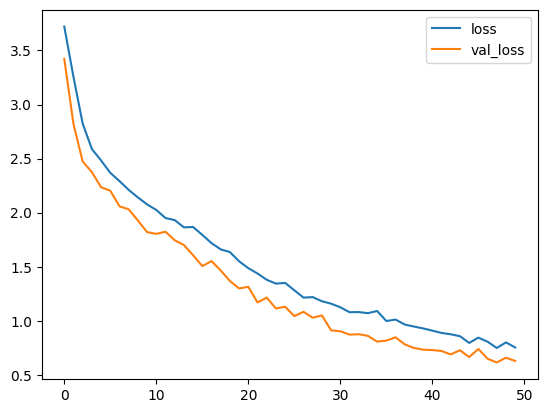

In [19]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')

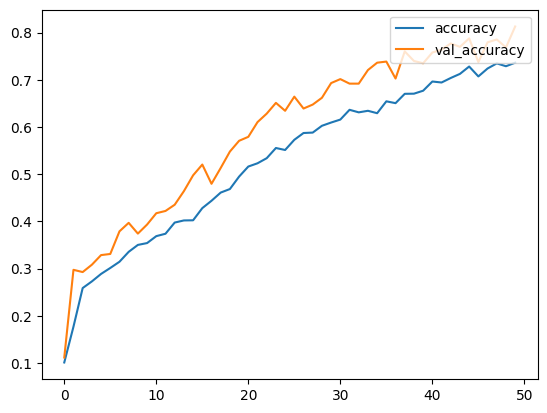

In [20]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')

El modelo modificado muestra una tendencia positiva tanto en la precisión de entrenamiento como en la de validación. La disminución de las pérdidas de entrenamiento y validación sugiere que el modelo está aprendiendo y generalizando bien.

La precisión de validación final de aproximadamente el 81,3% indica una mejora del rendimiento en comparación con el modelo inicial.

Esto resultados se alinean con las expectativas mencionadas anteriormente pero sin mejorar los parámetros del primer modelo.

## Resultados

De las modificaciones realizadas, observamos que el modelo de mejor desempeño fue el primero debido a su entrenamiento y a sus métricas obtenidas.

De la misma forma, se intentó visualizar las predicciones hechas por el modelo, sin embargo, debido a fallas técnicas, aún no se visualizan de manera correcta. Se espera que para la entrega final de este trabajo se incluyan las mejoras proporcionadas por el profesor, así como una visualización completa de todos los módulos

## Conclusiones

En conclusión, este proyecto de clasificación de señalamientos de tráfico ha sido un viaje de exploración y experimentación para lograr predicciones precisas y sólidas de nuestras clases objetivo.

Aprovechando una arquitectura de red neuronal convolucional (CNN), se realizaron diferentes procesos de entrenamiento, ajustando meticulosamente parámetros y arquitecturas para optimizar el rendimiento.

Se espera que al final de este trabajo se implementen las mejoras proporcionadas por el profesor.